In [1]:
#Qiskit Aer: Pulse simulation of a backend model
#This notebook shows how to use the Aer pulse simulator using a model generated from a backend. 
#In particular, we run a Rabi experiment to find a 𝜋-pulse amplitude on a model of the Armonk one qubit backend, generated from the FakeArmonk mock backend.

In [2]:
#Contents
#1.Imports
#2.Construct model from backend
#3.Run Rabi experiments and fit :math:pi`-pulse amplitude <#rabi>`__

In [2]:
#1.Imports
import numpy as np
#Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In [3]:
#Import PulseSimulator and PulseSystemModel for pulse simulation, as well as the mock Armonk backend:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

In [4]:
#2. Construct model from backend
#This section demonstrates the use of the PulseSystemModel.from_backend function for generating PulseSystemModel objects from a backend.
#Instantiate mock backend:
armonk_backend = FakeArmonk()

In [5]:
#Manual insertion of Hamiltonian parameters:
#Caution: Hamiltonian parameters are required for FAKE BACKEND
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
# Caution: the frequency of the qubit of the real backend, look up the frequency in the spec in IBMQ
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [6]:
#Generate model from backend:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [7]:
#3.Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

In [8]:
#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

# drive shape parameters
total_duration = 4096*3
total_sigma = total_duration/8
num_dur = 17
drive_duration = np.linspace(0, total_duration, num_dur)
drive_duration = np.delete(drive_duration, 0)
drive_sigma = np.linspace(0,total_sigma, num_dur)
drive_sigma = np.delete(drive_sigma,0)
print(drive_duration)
# drive amplitudes to use
num_exps = 100
drive_amps = np.linspace(0, 1.0, num_exps)
#drive_amps = 0.01


# list of drive channels
drive_channels = [DriveChannel(0)]

[  768.  1536.  2304.  3072.  3840.  4608.  5376.  6144.  6912.  7680.
  8448.  9216.  9984. 10752. 11520. 12288.]


In [9]:
from qiskit import pulse 
from qiskit.pulse import library
from qiskit.scheduler import measure 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: "measure" has been moved to "qiskit.pulse.macros"
  


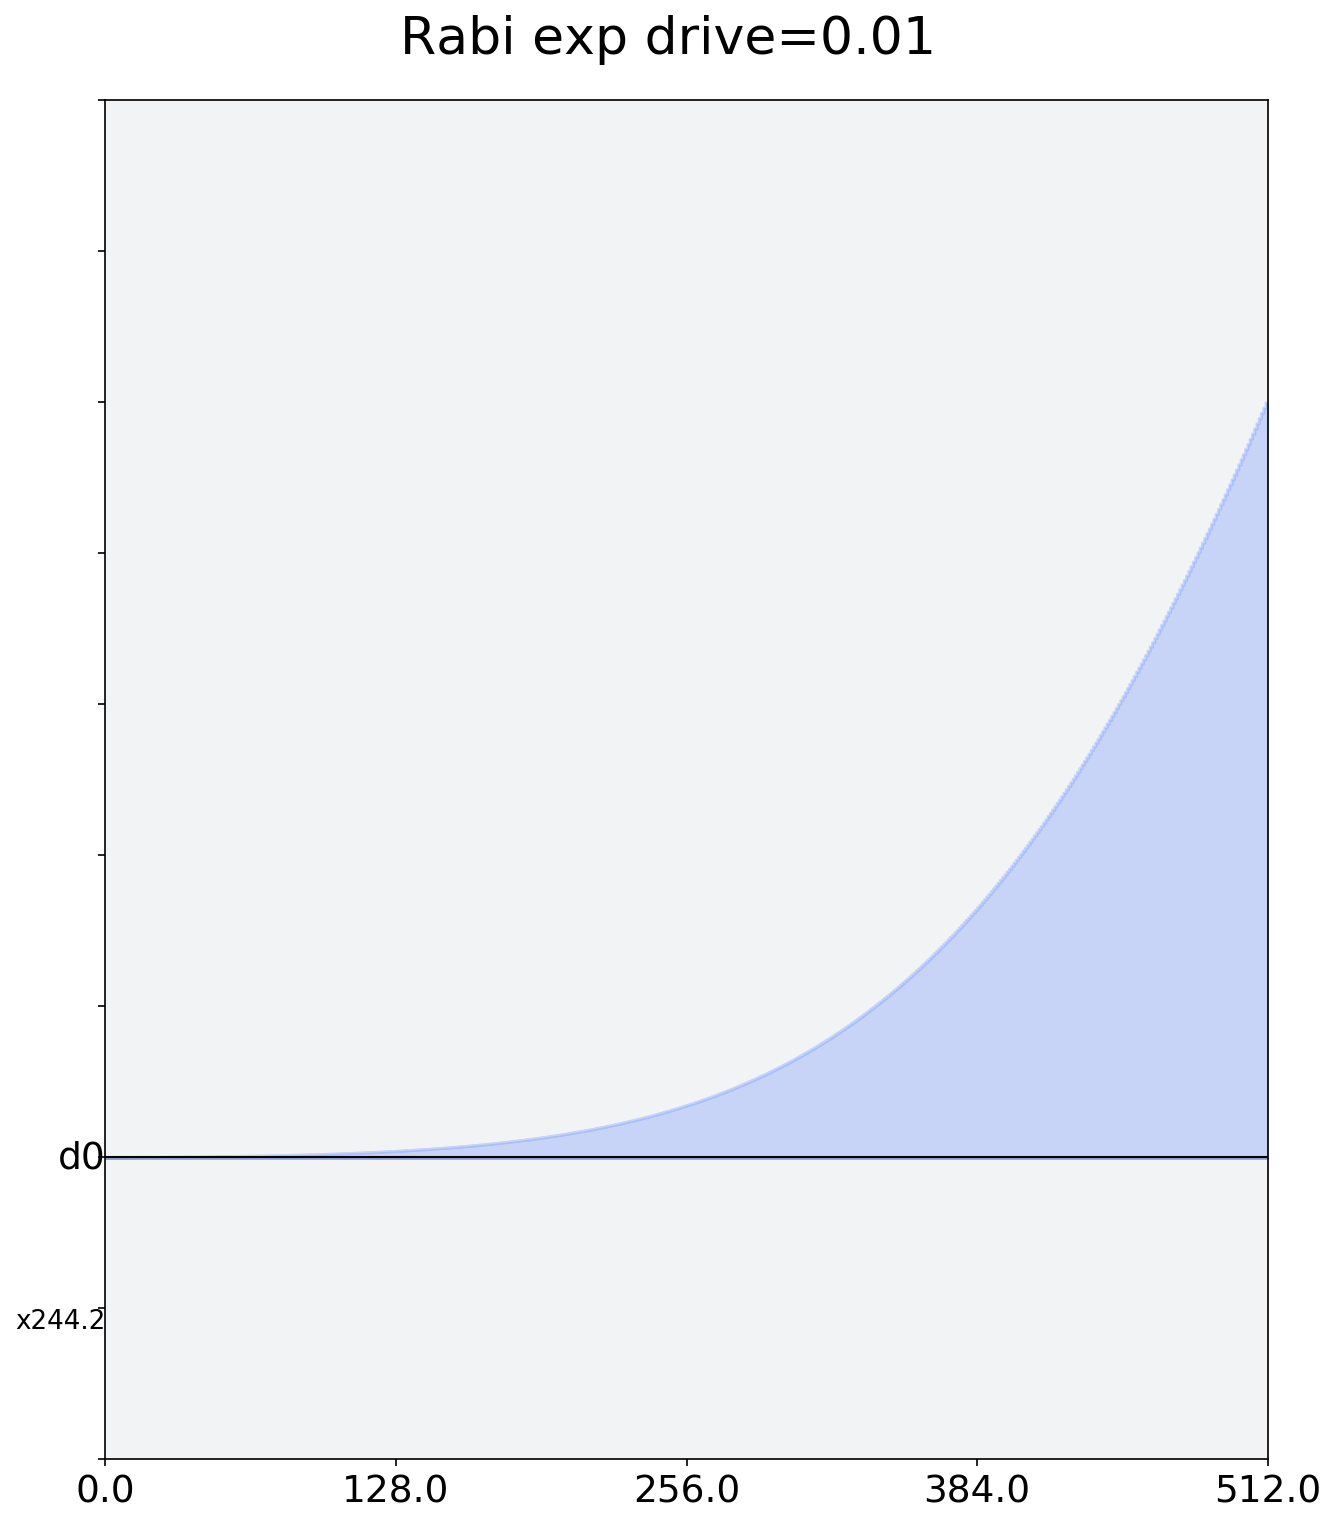

In [10]:
backend_sim = PulseSimulator()
#for amp in drive_amps:
amp = 0.01
rabi_schedules=[]
for i in range(len(drive_duration)):
    sched = pulse.Schedule(name='Rabi exp drive={}'.format(amp))
    sched += pulse.Play(library.Gaussian(int(drive_duration[i]),amp,int(drive_sigma[i])).get_waveform(),pulse.DriveChannel(qubit))
    sched += measure([qubit], armonk_backend) << sched.duration
    rabi_schedules.append(sched)
    
    #Assemble the qobj for job submission. 
    #When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.
rabi_schedules[1].draw(plot_range=[0,512])

    

In [11]:
rabi_qobj = assemble(rabi_schedules,
                 backend=backend_sim,
                 meas_level=2,
                 meas_return='avg',
                 shots=2048)
#Run the simulation:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


In [12]:
response = []
for i in range(len(drive_duration)):
    response.append(sim_result.get_counts(i).get('1', int(0))/2048)
len(response)

response
    

[0.00048828125,
 0.0,
 0.00390625,
 0.0029296875,
 0.00927734375,
 0.0078125,
 0.01611328125,
 0.015625,
 0.01904296875,
 0.02978515625,
 0.03173828125,
 0.03662109375,
 0.04931640625,
 0.052734375,
 0.060546875,
 0.0712890625]

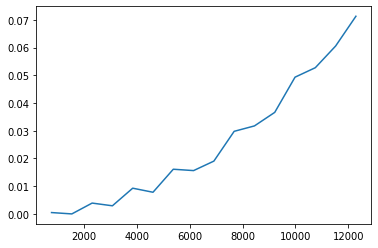

In [13]:
#response = response - np.mean(response)    

import matplotlib.pyplot as plt 
plt.plot(drive_duration,np.real(response))